## SNAP WPFB Tutorial
* requirements:
    * mlib_devel : [m2021a branch](https://github.com/liuweiseu/mlib_devel/tree/m2021a)
    * casper_dspdevel: [master_branch](https://github.com/talonmyburgh/casper_dspdevel/tree/master)
    * casperfpga : [py38 branch](https://github.com/liuweiseu/casperfpga/tree/py38)
    * design     : [snap_hdl_pfb_v4.slx](https://github.com/liuweiseu/snap_hdl_tut/blob/dev/snap_hdl_pfb_v4.slx)

### Step0: Import necessary packages

In [ ]:
import os
import sys
import casperfpga
import logging
import time
import redis
import numpy as np
import struct
import matplotlib.pyplot as plt
%matplotlib widget

### Step1: Set parameters

In [ ]:
'''
SNAP board info
'''
snap_ip  = '192.168.2.100'
port    = 69

#fpg_file = 'snap_hdl_pfb_v4_2023-08-01_1230.fpg'
fpg_file = 'snap_hdl_pfb_v4_2023-08-01_1541.fpg'
'''
Parameters for spectrameter
''' 
# sample freq
fs = 500
#fs = 1000
adc_ref = 10
# adc gain: it's voltage multplier inside the ADC IC.
adc_gain = 4
# acc_len
acc_len = 128


### Step2: Connect to the SNAP board 

In [ ]:
logger=logging.getLogger('snap')
logging.basicConfig(filename='snap.log',level=logging.DEBUG)
snap=casperfpga.CasperFpga(snap_ip, port, logger=logger)

### Step4: Upload fpg file

In [ ]:
fpg = '../fpg/'+fpg_file
print('fpg file: ',fpg)
snap.upload_to_ram_and_program(fpg)
# We should get system info in "upload_to_ran_and_program", but it seems there are some issues in the casperfpga
snap.get_system_information(fpg,initialise_objects=False)

### Step5: Init clk and adc

In [ ]:
# numChannel depends on fs
if(fs==1000):
    numChannel = 1
    inputs = [1,1,1,1]
elif(fs==500):
    numChannel = 2
    inputs = [1,1,3,3]
# init adc and clk
adc=snap.adcs['snap_adc']
adc.ref = adc_ref
adc.selectADC()
adc.init(sample_rate=fs,numChannel=numChannel)
adc.rampTest(retry=True)
adc.adc.selectInput(inputs)
adc.selectADC()
adc.set_gain(adc_gain)

## Step6: Write registers

In [ ]:
snap.registers['acc_len'].write_int(acc_len)
snap.registers['sys_ctl'].write_int(1)
time.sleep(0.1)
snap.registers['sys_ctl'].write_int(0)
time.sleep(0.1)
snap.registers['sys_ctl'].write_int(2)
time.sleep(0.1)
snap.registers['sys_ctl'].write_int(0)
snap.registers['pfb_status'].read_uint()

### Step6: read spectra data from snapshot

In [ ]:
snap.registers['sw_trig'].write_int(0)
time.sleep(1)
snap.registers['sw_trig'].write_int(1)
snap.snapshots['pwr_snapshot0_ss0'].arm()
data0 = snap.snapshots['pwr_snapshot0_ss0'].read()['data']
snap.snapshots['pwr_snapshot0_ss1'].arm()
data1 = snap.snapshots['pwr_snapshot0_ss1'].read()['data']
d0=np.array(data0['data'])
d1=np.array(data1['data'])
d=np.array([d0,d1])
dat0 = d.reshape(1,1024)
dat0=dat0.transpose()


snap.snapshots['pwr_snapshot1_ss0'].arm()
data0 = snap.snapshots['pwr_snapshot1_ss0'].read()['data']
snap.snapshots['pwr_snapshot1_ss1'].arm()
data1 = snap.snapshots['pwr_snapshot1_ss1'].read()['data']
d0=np.array(data0['data'])
d1=np.array(data1['data'])
d=np.array([d0,d1])
dat1 = d.reshape(1,1024)
dat1=dat1.transpose()

### Step7: plot the data

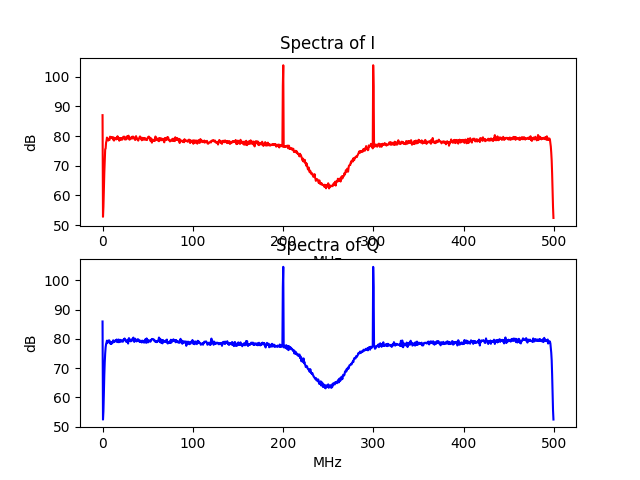

In [16]:
l=dat0.shape[0]
df=fs/l
x=np.arange(0,l)*df
fig=plt.figure()
sub=fig.add_subplot(211)
sub.plot(x,10*np.log10(dat0),c='red')
sub.set_title('Spectra of I')
sub.set_xlabel('MHz')
sub.set_ylabel('dB')
sub=fig.add_subplot(212)
sub.plot(x,10*np.log10(dat1),c='blue')
sub.set_title('Spectra of Q')
sub.set_xlabel('MHz')
sub.set_ylabel('dB')
plt.show()
plt.tight_layout()